# Libraries

In [1]:
import os
import numpy as np
from pandas.io.parsers import read_csv
from pandas import DataFrame
from sklearn.utils import shuffle

import theano
from nolearn.lasagne import NeuralNet, TrainSplit
# nerual net layers definition
from lasagne import layers
# common gradient descent method
from lasagne.updates import nesterov_momentum
# for transforming images stochastically per batch on the fly
from nolearn.lasagne import BatchIterator

# for evaluating training time
from time import time
from datetime import datetime
# for storing and loading the trained models
import pickle

# for plotting images
import matplotlib.pyplot as plt
# for evaluating MSE
from sklearn.metrics import mean_squared_error

# Increase Python's recursion limit because the neural net model is large enough
import sys
sys.setrecursionlimit(10000)

from collections import OrderedDict
from sklearn.base import clone

try:
    from lasagne.layers.cuda_convnet import Conv2DCCLayer as Conv2DLayer
    from lasagne.layers.cuda_convnet import MaxPool2DCCLayer as MaxPool2DLayer
except ImportError:
    Conv2DLayer = layers.Conv2DLayer
    MaxPool2DLayer = layers.MaxPool2DLayer
    
np.random.seed(42)

1 #define _CUDA_NDARRAY_C
2 
3 #include <Python.h>
4 #include <structmember.h>
5 #include "theano_mod_helper.h"
6 
7 #include <numpy/arrayobject.h>
8 #include <iostream>
9 
10 #include "cuda_ndarray.cuh"
11 
12 #ifndef CNMEM_DLLEXPORT
13 #define CNMEM_DLLEXPORT
14 #endif
15 
16 #include "cnmem.h"
17 #include "cnmem.cpp"
18 
19 //If true, when there is a gpu malloc or free error, we print the size of allocated memory on the device.
20 #define COMPUTE_GPU_MEM_USED 0
21 
22 //If true, we fill with NAN allocated device memory.
23 #define ALLOC_MEMSET 0
24 
25 //If true, we print out when we free a device pointer, uninitialize a
26 //CudaNdarray, or allocate a device pointer
27 #define PRINT_FREE_MALLOC 0
28 
29 //If true, we do error checking at the start of functions, to make sure there
30 //is not a pre-existing error when the function is called.
31 //You probably need to set the environment variable
32 //CUDA_LAUNCH_BLOCKING=1, and/or modify the CNDA_THREAD_SYNC
33 //preprocessor macro 

449         const int * dim,  \
450         const float * a_data, const int * a_str, \
451         float * z_data, const int * z_str) \
452 { \
453     const unsigned int idx = blockIdx.x * blockDim.x + threadIdx.x; \
454     const unsigned int numThreads = blockDim.x * gridDim.x; \
455  \
456     for (unsigned int i = idx; i < numEls; i += numThreads) \
457     { \
458         unsigned int ii = i; \
459         const float * a_i = a_data; \
460         float * z_i = z_data; \
461         for (unsigned int _d = 0; _d < nd; ++_d) \
462         { \
463             unsigned int d = nd - _d-1;  \
464             int i_d = ii % dim[d]; /* i_d is our position in the d'th dimension   */ \
465             ii = ii / dim[d]; \
466             a_i += i_d * a_str[d]; /* increment our a and z pointers by i_d elements */ \
467             z_i += i_d * z_str[d]; \
468         } \
469         z_i[0] = F(a_i[0]); \
470     } \
471 }
472 
473 template<typename T> __device__ T unary_copy(T a) { return a;

1512         }
1513         size *= (unsigned int) CudaNdarray_HOST_DIMS(self)[i];
1514     }
1515     CudaNdarray * rval = (CudaNdarray *)CudaNdarray_New();
1516     if (!rval || CudaNdarray_alloc_contiguous(rval, self->nd, CudaNdarray_HOST_DIMS(self)))
1517     {
1518         Py_XDECREF(rval);
1519         return NULL;
1520     }
1521 
1522     if(CudaNdarray_SIZE((CudaNdarray *)py_self)==0 && CudaNdarray_SIZE((CudaNdarray *)py_other)==0){
1523       return (PyObject *) rval;
1524     }
1525 
1526     int threads_per_block = std::min(size, (unsigned int)NUM_VECTOR_OP_THREADS_PER_BLOCK);
1527     int n_blocks = std::min(ceil_intdiv(size,(unsigned int)threads_per_block), (unsigned int)NUM_VECTOR_OP_BLOCKS);
1528     kAdd_contiguous<<<n_blocks,threads_per_block>>>(
1529             self->devdata, other->devdata, rval->devdata, size);
1530     CNDA_THREAD_SYNC;
1531     cudaError_t err = cudaGetLastError();
1532     if( cudaSuccess != err)
1533     {
1534         PyErr_Format(PyExc_Runti

2746     // Do not do this check, as ExtractDiag needs that, and NumPy does not seem
2747     // to do it.
2748     npy_intp dims[PyTuple_Size(value)];
2749     for(int i=0; i < CudaNdarray_NDIM(self); i++){
2750         dims[i] = CudaNdarray_HOST_DIMS(self)[i];
2751     }
2752     if (!PyArray_CheckStrides(4,
2753                               CudaNdarray_NDIM(self),
2754                               0, 0,
2755                               dims,
2756                               newstrides_bytes)){
2757         PyErr_SetString(PyExc_ValueError, "bad new strides");
2758         return -1;
2759         }
2760     */
2761     for(int i=0; i < CudaNdarray_NDIM(self); i++){
2762         CudaNdarray_set_stride(self, i, newstrides[i]);
2763     }
2764     return 0;
2765 }
2766 
2767 static PyObject *
2768 CudaNdarray_get_dev_data(CudaNdarray *self, void *closure)
2769 {
2770     float * p =  CudaNdarray_DEV_DATA(self);
2771     //printf("get_dev_data %p %li \n", p, (long int)p );
2772    

3849     }
3850     //N.B. XDECREF and XINCREF are no-ops for NULL pointers
3851     if (self->base != orig_base)
3852     {
3853         Py_XDECREF(self->base);
3854         self->base = orig_base;
3855         Py_XINCREF(self->base);
3856     }
3857     self->data_allocated = 0;
3858     self->devdata = data;
3859     return 0;
3860 }
3861 
3862 static __global__ void k_copy_1d(const int N, const float * x, const int sx, float * y, const int sy)
3863 {
3864     for (int i = threadIdx.x + blockIdx.x * blockDim.x; i < N; i += gridDim.x*blockDim.x)
3865     {
3866         y[i*sy] = x[i*sx];
3867     }
3868 }
3869 
3870 // N1 through N4 are the size of y
3871 static __global__ void k_copy_4d(const int N1,
3872         const int N2, const int N3, const int N4,
3873         const float * x, const int sx1, const int sx2, const int sx3,
3874         const int sx4,  float * y, const int sy1, const int sy2,
3875         const int sy3, const int sy4)
3876 {
3877     // These must be made int in

4944         {
4945             newdims[i] = 1;
4946             newstrides[i] = 0;
4947         }
4948         else if(dims_taken[pattern[i]])
4949         {
4950             PyErr_Format(PyExc_ValueError, "Cudandarray_dimshuffle: invalid pattern for Cudandarray_dimshuffle. You used the dimensions %d multiple time",
4951                          pattern[i]);
4952             free(newdims);
4953             return -1;
4954         }
4955         else if (pattern[i]>= self->nd)
4956         {
4957             PyErr_Format(PyExc_ValueError, "Cudandarray_dimshuffle: invalid pattern for Cudandarray_dimshuffle. You asked for a dimensions that don't exist %d for a %d dims CudaNdarray",
4958                          pattern[i], self->nd);
4959             free(newdims);
4960             return -1;
4961         }
4962         else
4963         {
4964             newdims[i] = CudaNdarray_HOST_DIMS(self)[pattern[i]];
4965             newstrides[i] = CudaNdarray_HOST_STRIDES(self)[pattern[i]];
49

nvcc fatal   : Cannot find compiler 'cl.exe' in PATH

['nvcc', '-shared', '-O3', '-Xlinker', '/DEBUG', '-D HAVE_ROUND', '-m64', '-Xcompiler', '-DCUDA_NDARRAY_CUH=mc72d035fdf91890f3b36710688069b2e,-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION,/Zi,/MD', '-I"C:\\Users\\chuco\\Anaconda3\\envs\\bunny_theano_dell\\lib\\site-packages\\theano\\sandbox\\cuda"', '-I"C:\\Users\\chuco\\Anaconda3\\envs\\bunny_theano_dell\\lib\\site-packages\\numpy\\core\\include"', '-I"C:\\Users\\chuco\\Anaconda3\\envs\\bunny_theano_dell\\include"', '-I"C:\\Users\\chuco\\Anaconda3\\envs\\bunny_theano_dell\\lib\\site-packages\\theano\\gof"', '-L"C:\\Users\\chuco\\Anaconda3\\envs\\bunny_theano_dell\\libs"', '-L"C:\\Users\\chuco\\Anaconda3\\envs\\bunny_theano_dell"', '-o', 'C:\\Users\\chuco\\AppData\\Local\\Theano\\compiledir_Windows-10-10.0.16299-SP0-Intel64_Family_6_Model_94_Stepping_3_GenuineIntel-3.5.4-64\\cuda_ndarray\\cuda_ndarray.pyd', 'mod.cu', '-lcublas', '-lpython35', '-lcudart']


C:\Users\chuco\Anaconda3\envs\bunny_theano_dell\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 1. Change these to your own paths

In [18]:
# put in a csv containing your augmented data
# you can pass it in
FAUGMENTED1 = '?????.csv'
FAUGMENTED2 = '?????.csv'
FAUGMENTED3 = '?????.csv'
FAUGMENTED4 = '?????.csv'
FAUGMENTED5 = '?????.csv'
FAUGMENTED6 = '?????.csv'
FAUGMENTED7 = '?????.csv'

augmented_data_path_combined = [FAUGMENTED1,
                               FAUGMENTED2,
                               FAUGMENTED3,
                               FAUGMENTED4,
                               FAUGMENTED5,
                               FAUGMENTED6,
                               FAUGMENTED7
                               ]

# train dev indices paths
IDXTRAIN = 'train_indices.txt'
IDXDEV = 'dev_indices.txt'

# specialists paths
FILE_NAMES = ['specialist_mouth_center_saved_params.txt',
             'specialist_nose_tip_saved_params.txt',
             'specialist_mouth_corner_saved_params.txt',
             'specialist_mouth_center_saved_params.txt',
             'specialist_eye_corner_saved_params.txt',
             'specialist_eyebrow_saved_params.txt']

# net12 params
net12_params_path = "C:/Users/chuco/Documents/MIDS W207/net_pretrain_saved_params.txt"

# 1.5 (Edited code for loading augmented data)

In [21]:
# Write function to load the data
# Normalize the target -- coordinates : current grid 96by96
# Normalize the features -- pixels : current range 255

def load_augmented(cols = None, path=FAUGMENTED1):
    """Loads data from FTEST if *test* is True, otherwise from FTRAIN. 
    Pass a list of *cols* if you're only interested in a subset of the target columns"""
    
    df = read_csv(os.path.expanduser(path)) #Load pandas dataframe
    
    # The Image column has pixel values separated by space
    # convert these values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))
    
    if cols: # can selectively load some targets by specifying them in the cols argument
        df = df[list(cols) + ['Image']]
        
    print(df.count()) # prints the number of values for each column
    df = df.dropna()

    # drop all rows that have missing values in them. 
    # if argument cols in not specified, this reduce from 7049 partial to 2140 full examples
    # potentially a problem training a neural net with fewer examples
    # should consider data augmentation in upcoming models
    
    # make feature matrix X
    # first convert pixel values from pandas 1D series to numpy 2D array
    # normalize pixel valuaes
    X = np.vstack(df['Image'].values)/255. # scale pixel values to [0,1]
    X = X.astype(np.float32) # make sure numeric val are float32
    # X is numpy.ndarray, shape (2140, 9216) == 2140 examples, 96 grid * 96 grid
    
    # Loading the 30 labels(targets)(keypoints) y for each face into an array
    if not test: # only training examples have target columns
        
        y = df[df.columns[:-1]].values #last column is X, we want the y targets here
        # y is numpy.ndarray, shape(2140, 30) -- 7049 examples, 30 targets each
        
        y = (y - 48) / 48 # scale target coordinates to [-1.1] (currently 96 by 96)
        X, y = shuffle(X, y, random_state = 42) #shuffle training data
        y = y.astype(np.float32)
        
    else:
        y = None # development data has no targets available
        
    return X,y

# When using convolutional layers in Lasagne, we have to prepare the input data such 
# that each sample is no longer a flat vector of 9,216 pixel intensities, 
# but a three-dimensional matrix with shape (c, 0, 1), where c is the number of channels (colors), 
# and 0 and 1 correspond to the x and y dimensions of the input image. In our case, 
# the concrete shape will be (1, 96, 96), because we're dealing with a single (gray) color 
# channel only.

def load2d(cols=None, path=FAUGMENTED1):
    X, y, idx = load_augmented(cols=cols, path=path)
    X = X.reshape(-1, 1, 96, 96)
    return X, y

flip_indices = [
    (0, 2), (1, 3),
    (4, 8), (5, 9), (6, 10), (7, 11),
    (12, 16), (13, 17), (14, 18), (15, 19),
    (22, 24), (23, 25),
    ]

# 2. Copied Junks

In [20]:
class FlipBatchIterator(BatchIterator):
    flip_indices = [
        (0, 2), (1, 3),
        (4, 8), (5, 9), (6, 10), (7, 11),
        (12, 16), (13, 17), (14, 18), (15, 19),
        (22, 24), (23, 25),
        ]

    def transform(self, Xb, yb):
        Xb, yb = super(FlipBatchIterator, self).transform(Xb, yb)

        # Flip half of the images in this batch at random:
        bs = Xb.shape[0] #number of examples
        indices = np.random.choice(bs, bs // 2, replace=False) #choose half of them randomly
        Xb[indices] = Xb[indices, :, :, ::-1] #flip these guys randomly

        if yb is not None:
            # Horizontal flip of all x coordinates:
            yb[indices, ::2] = yb[indices, ::2] * -1

            # Swap places, e.g. left_eye_center_x -> right_eye_center_x
            for a, b in self.flip_indices:
                yb[indices, a], yb[indices, b] = (
                    yb[indices, b], yb[indices, a])

        return Xb, yb
    
def float32(k):
    return np.cast['float32'](k)


class AdjustVariable(object):
    def __init__(self, name, start=0.03, stop=0.001):
        self.name = name
        self.start, self.stop = start, stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs)

        epoch = train_history[-1]['epoch']
        new_value = float32(self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)
        
class EarlyStopping(object):
    def __init__(self, patience=100):
        self.patience = patience
        self.best_valid = np.inf
        self.best_valid_epoch = 0
        self.best_weights = None

    def __call__(self, nn, train_history):
        current_valid = train_history[-1]['valid_loss']
        current_epoch = train_history[-1]['epoch']
        if current_valid < self.best_valid:
            self.best_valid = current_valid
            self.best_valid_epoch = current_epoch
            self.best_weights = nn.get_all_params_values()
        elif self.best_valid_epoch + self.patience < current_epoch:
            print("Early stopping.")
            print("Best valid loss was {:.6f} at epoch {}.".format(
                self.best_valid, self.best_valid_epoch))
            nn.load_params_from(self.best_weights)
            raise StopIteration()
            
            
net12 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', Conv2DLayer),
        ('pool1', MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),
        ('conv2', Conv2DLayer),
        ('pool2', MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),
        ('conv3', Conv2DLayer),
        ('pool3', MaxPool2DLayer),
        ('dropout3', layers.DropoutLayer),
        ('hidden4', layers.DenseLayer),
        ('dropout4', layers.DropoutLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    dropout1_p=0.1,
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    dropout2_p=0.2,
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    dropout3_p=0.3,
    hidden4_num_units=1000,
    dropout4_p=0.5,
    hidden5_num_units=1000,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=theano.shared(float32(0.03)),    update_momentum=theano.shared(float32(0.9)),

    regression=True,
    batch_iterator_train=FlipBatchIterator(batch_size=128),
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        EarlyStopping(patience=200),
        ],
    max_epochs=1000,
    verbose=1,
    )

SPECIALIST_SETTINGS = [
    dict(
        columns=(
            'left_eye_center_x', 'left_eye_center_y',
            'right_eye_center_x', 'right_eye_center_y',
            ),
        flip_indices=((0, 2), (1, 3)),
        ),

    dict(
        columns=(
            'nose_tip_x', 'nose_tip_y',
            ),
        flip_indices=(),
        ),

    dict(
        columns=(
            'mouth_left_corner_x', 'mouth_left_corner_y',
            'mouth_right_corner_x', 'mouth_right_corner_y',
            'mouth_center_top_lip_x', 'mouth_center_top_lip_y',
            ),
        flip_indices=((0, 2), (1, 3)),
        ),

    dict(
        columns=(
            'mouth_center_bottom_lip_x',
            'mouth_center_bottom_lip_y',
            ),
        flip_indices=(),
        ),

    dict(
        columns=(
            'left_eye_inner_corner_x', 'left_eye_inner_corner_y',
            'right_eye_inner_corner_x', 'right_eye_inner_corner_y',
            'left_eye_outer_corner_x', 'left_eye_outer_corner_y',
            'right_eye_outer_corner_x', 'right_eye_outer_corner_y',
            ),
        flip_indices=((0, 2), (1, 3), (4, 6), (5, 7)),
        ),

    dict(
        columns=(
            'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y',
            'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y',
            'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y',
            'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y',
            ),
        flip_indices=((0, 2), (1, 3), (4, 6), (5, 7)),
        ),
    ]

SPECIALIST_NAMES = ["eye_center", "nose_tip", "mouth_corner", "mouth_center", "eye_corner", "eyebrow"]
SPECIALIST_OUTPUTNODES = [4,2,6,2,8,8]

# 5. TRAIN MODEL WITH AUGMENTED DATA (NOT SPECIALIST) (CAUTION)
- Make sure all augmented data passed in have all 30 target labels

In [ ]:
# Make sure all augmented data passed in have all 30 target labels
X_augmented, Y_augmented, augmented_idx = load2d(cols=None, path=?????)

In [ ]:
net12_augmented = clone(net12)
net12_augmented.max_epochs = 500

In [ ]:
net12_augmented.load_params_from(net12_params_path)

In [ ]:
# put in your own augmented and transformed data
net12_augmented.fit(X_augmented, Y_augmented)

# 6. TRAIN MODEL WITH AUGMENTED DATA (SPECIALIST) (CAUTION)

In [22]:
# Load Specialists
models = OrderedDict()
for i in range(len(SPECIALIST_NAMES)):
    specialist_name = SPECIALIST_NAMES[i] 
    file_name = FILE_NAMES[i]
    num_output_nodes = SPECIALIST_OUTPUTNODES[i]
    specialist_model = clone(net12)
    specialist_model.max_epochs = 3000
    specialist_model.output_num_units = num_output_nodes
    
    specialist_model.load_params_from(file_name)
    models[specialist_name] = specialist_model

C:\Users\chuco\Anaconda3\envs\bunny_theano_dell\lib\site-packages\sklearn\base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
C:\Users\chuco\Anaconda3\envs\bunny_theano_dell\lib\site-packages\sklearn\base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
C:\Users\chuco\Anaconda3\envs\bunny_theano_dell\lib\site-packages\sklearn\base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
C:\Users\chuco\Anaconda3\envs\bunny_theano_dell\lib\site-packages\sklearn\base.py:114: D

FileNotFoundError: [Errno 2] No such file or directory: 'specialist_mouth_center_saved_params.txt'

In [ ]:
specialist_setting_augmented = SPECIALIST_SETTINGS[1] # ! change this to correspond to your specialist
specialist_name_augmented = SPECIALIST_SETTINGS[1] 
X_specialist, y_specialist, idx = load2d(cols=cols, path = "?????") # !! change to ur own augmented data path


setting = specialist_setting_augmented
specialist_name = specialist_name_augmented
net_pretrain = models[specialist_name_augmented]
cols = setting['columns']
print ("-------------------------------------------------------")
print ("y output nodes:", y_specialist.shape[1])
print ("# examples used:", X_specialist.shape[0])

# clone pretrained net
model = clone(net_pretrain) 
# adjust number of output nodes
model.output_num_units = y_specialist.shape[1] 
# adjust indices to flip
model.batch_iterator_train.flip_indices = setting['flip_indices']

# redefine max number to epochs to lower
model.max_epochs = 500 # !

model.load_params_from(net_pretrain)   

print("Training model for columns {} for {} epochs".format(cols, model.max_epochs))
model.fit(X_specialist, y_specialist)

# save this model please (we need this for reporting)
model.save_params_to(???".csv") 

## Should be working below, but please debug if not working

### 9.8 Plot their error curves

In [28]:
def rebin( a, newshape ):
    from numpy import mgrid
    assert len(a.shape) == len(newshape)

    slices = [ slice(0,old, float(old)/new) for old,new in zip(a.shape,newshape) ]
    coordinates = mgrid[slices]
    indices = coordinates.astype('i')   #choose the biggest smaller integer index
    return a[tuple(indices)]

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


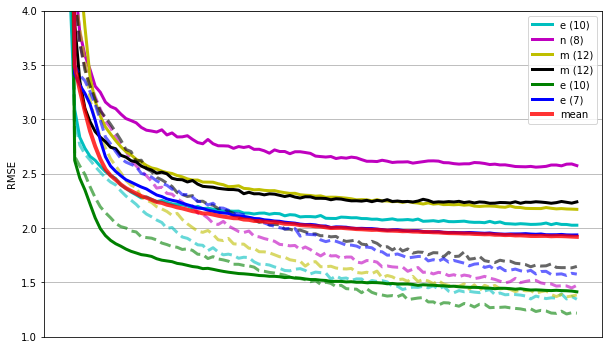

In [35]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_color_cycle(['c', 'c', 'm', 'm', 'y', 'y', 'k', 'k', 'g', 'g', 'b', 'b'])

valid_losses = []
train_losses = []

for model_number, (cg, model) in enumerate(models.items(), 1):
    valid_loss = np.array([i['valid_loss'] for i in model.train_history_])
    train_loss = np.array([i['train_loss'] for i in model.train_history_])
    valid_loss = np.sqrt(valid_loss) * 48
    train_loss = np.sqrt(train_loss) * 48
    valid_loss = rebin(valid_loss, (100,))
    train_loss = rebin(train_loss, (100,))
    valid_losses.append(valid_loss)
    train_losses.append(train_loss)
    ax.plot(valid_loss,label='{} ({})'.format(cg[0], len(cg)), linewidth=3)
    ax.plot(train_loss,linestyle='--', linewidth=3, alpha=0.6)
    ax.set_xticks([])

weights = np.array([m.output_num_units for m in models.values()],dtype=float)
weights /= weights.sum()
mean_valid_loss = (np.vstack(valid_losses) * weights.reshape(-1, 1)).sum(axis=0)
ax.plot(mean_valid_loss, color='r', label='mean', linewidth=4, alpha=0.8)
ax.legend()
ax.set_ylim((1.0, 4.0))
ax.grid()
plt.ylabel("RMSE")
plt.show()

In [40]:
mean_valid_loss[99]

1.9193458468468299

### Study In-sample Training and Validation Loss

Note that this "Training" and "Validation" data came from our 1940 training examples only. The Neural Net call automatically split 0.1 of these 1940 examples internally for its validation set. This has nothing to do with our development set, which is necessary for us to later compare with other models such as SVM or Logistic Regression.

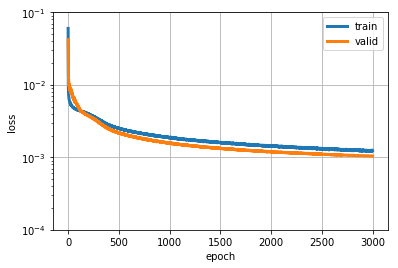

In [96]:
# object net12 keeps training history for each epoch
# we can access this record
train_loss = np.array([i["train_loss"] for i in net_pretrain.train_history_])
valid_loss = np.array([i["valid_loss"] for i in net_pretrain.train_history_])
plt.plot(train_loss, linewidth=3, label="train")
plt.plot(valid_loss, linewidth=3, label="valid")
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim(1e-4,1e-1)
plt.yscale("log")
plt.show()

In [19]:
# Our validation error is 0.003255 here
# we need to convert this back 
np.sqrt(0.00079)*48
# now it returns a proxy value for the Kaggle board score

1.3491330549652989

### 11. Plot in-sample predictions : training set
how well does the model fit to training examples fed into it?

In [16]:
def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap = 'gray')
    axis.scatter(y[0::2]*48+48, y[1::2]*48+48, marker='x', s=10)

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


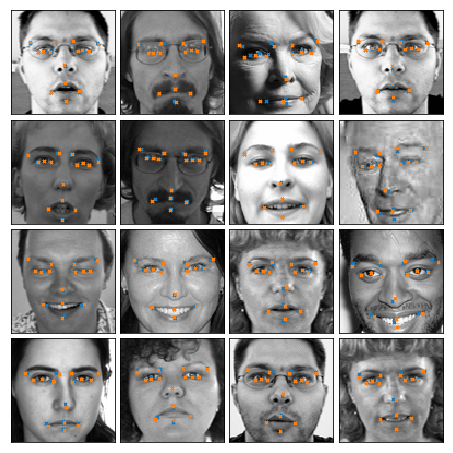

In [17]:
# load test set and predict
y_train_pred = net12.predict(X_train)

fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# predicted by model
for i in range(16):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    plot_sample(X_train[i], y_train_pred[i], ax)

# training labels
for i in range(16):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    plot_sample(X_train[i], y_train[i], ax)    

plt.show()

# cyan--our model prediction on training examples
# orange--real keypoints on training examples

### 12. Plot out-of-sample predictions : development set
how well does the model perform on the development set?

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


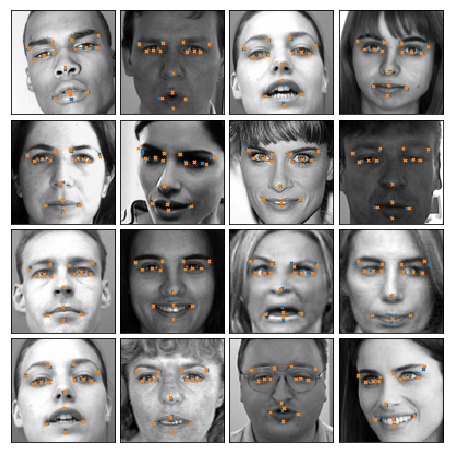

In [18]:
# load test set and predict
#X, _ = load(test=True)
y_dev_pred = net12.predict(X_dev)

fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    plot_sample(X_dev[i], y_dev_pred[i], ax)

for i in range(16):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    plot_sample(X_dev[i], y_dev[i], ax)
    
plt.show()

# cyan--our model prediction on development examples
# orange--real keypoints on development examples

### 12.5 Out-of-sample MSE: Development Set

In [19]:
mean_squared_error(y_dev, y_dev_pred)

0.00086455792

In [20]:
np.sqrt(mean_squared_error(y_dev, y_dev_pred))*48

1.4113615751266479

### 13. How will it look on the test set?
Note that we have no labels available, this is just a preview of how the model will perform on test set

ImageId    1783
Image      1783
dtype: int64


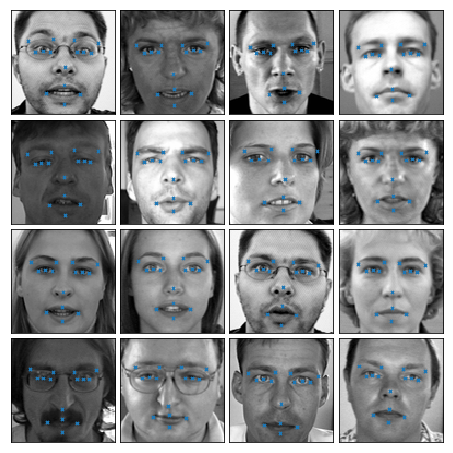

In [21]:
# load test set and predict
X_test, _ = load2d(test=True)
y_test_pred = net12.predict(X_test)

fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    plot_sample(X_test[i], y_test_pred[i], ax)
    
plt.show()